# Creating layouts for fabrication by programming KLayout

### Software installation:

***KLayout***

> pip install klayout

***SiEPIC-Tools***

1) via pip from PyPI distribution, 

> pip install siepic

2) or, via pip & GitHub Desktop:

> python -m pip install -e '/Users/lukasc/Documents/GitHub/SiEPIC-Tools/klayout_dot_config/python'


***Your Choosen PDK and Library***

I am using SiEPICfab-EBeam-ZEP-PDK

Follow the instructions outlined in the README here for installation:

https://github.com/SiEPIC/SiEPICfab-EBeam-ZEP-PDK

Or you can download directly through klayout (havent tried this method yet)

Importing the PDK can be generalized to any PDK in with the import method i have listed below!


In [1]:
import pya
from pya import *
import SiEPIC
from SiEPIC._globals import Python_Env
from SiEPIC.scripts import connect_cell, connect_pins_with_waveguide, zoom_out, export_layout
from SiEPIC.utils import create_cell2, get_layout_variables
from SiEPIC.utils.layout import new_layout, floorplan, coupler_array
from SiEPIC.extend import to_itype
from SiEPIC.verification import layout_check
import numpy as np
from SiEPIC.scripts import connect_pins_with_waveguide, connect_cell
import os
import sys


KLayout SiEPIC-Tools version 0.5.24
SiEPIC-Tools is up to date (0.5.24 vs 0.5.24).
Version check, time: 0.573631763458252 seconds


In [2]:

if Python_Env == 'Script':

    # Define the path to your local PDK
    path_to_pdk = r"E:\OneDrive - UBC\Documents\GitHub"
    # path_GitHub = r"C:\Users\gamem\OneDrive - UBC\Documents\GitHub"

    sys.path.insert(0, os.path.join(path_to_pdk, "SiEPICfab-EBeam-ZEP-PDK"))

    # Now try importing the PDK
    import SiEPICfab_EBeam_ZEP



SiEPICfab-EBeam-ZEP Python module: siepicfab_ebeam_zep, KLayout technology: SiEPICfab_EBeam_ZEP
SiEPICfab-EBeam-ZEP Python module: pymacros, v0.1.5
Libraries associated with Technology SiEPICfab_EBeam_ZEP: ['SiEPICfab_EBeam_ZEP', 'SiEPICfab_EBeam_ZEP_Beta']
Libraries associated with Technology SiEPICfab_EBeam_ZEP: ['SiEPICfab_EBeam_ZEP', 'SiEPICfab_EBeam_ZEP_Beta']


In [3]:
tech_name = 'SiEPICfab_EBeam_ZEP'  # Can change this
top_cell_name = 'MateoBC'  # Change this to the name of the top cell from the floorplan

chip_name = 'SiEPICfab_ZEP_SNSPDPASSIVE_thin'  # Change this to the name of the .oas file from the folder gds_floorplan
chip_folder = 'SiEPICfab_ZEP_SNSPDPASSIVE_202504'


chip_file = os.path.join("gds_floorplan", f"{chip_name}.oas")  # Main chip file in floorplan
layout_file = os.path.join("designs", f"{top_cell_name}.oas")  # Name of the soon-to-be chip


In [4]:
"""
This script is used to extract a cell from a floorplan and save it as a GDS file.
Worry less about it, just run it and it will do the job.
"""

_, _ly = new_layout(tech_name, "test", GUI=True, overwrite = False)
_ly.read(chip_file)
_top_cell = _ly.cell(top_cell_name)
_top_cell.write(layout_file) #save the layout to a GDS file

In [5]:
"""
Creates a new layout and a new floorplan
"""

# top_cell, ly = new_layout(tech_name, "test", GUI=True, overwrite = True)
# floorplan(top_cell, 605e3, 410e3)
# dbu = ly.dbu

'\nCreates a new layout and a new floorplan\n'

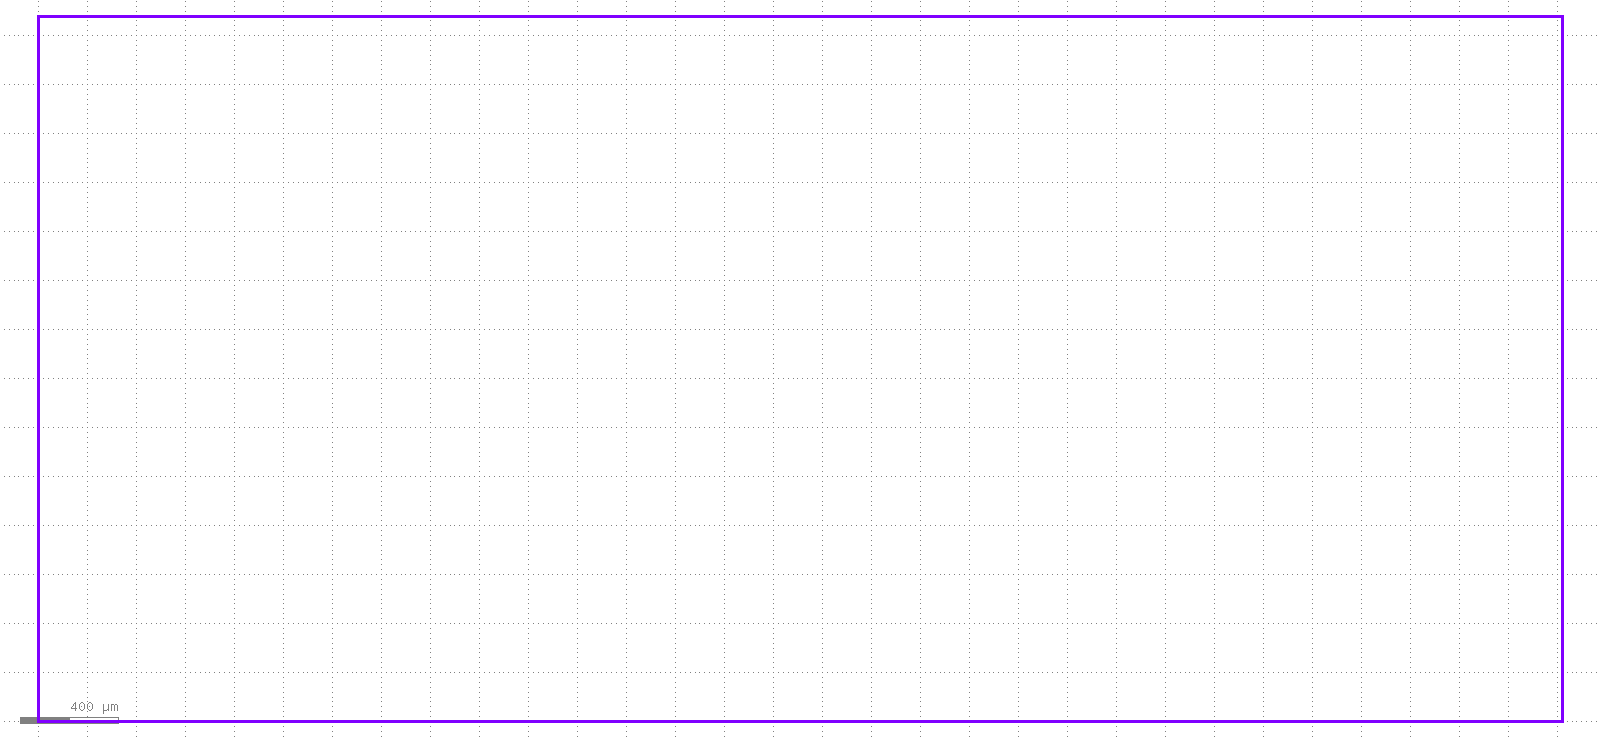

Could not connect to klive server. Is klayout open and klive plugin installed?


In [6]:
"""
This script is used to open a GDS file and display it in KLayout.
Creates a new layout and reads the GDS file the above cell made.
"""


_, ly = new_layout(tech_name, "test", GUI=True, overwrite = False)
ly.read(layout_file)
# Access the top cell
top_cell = ly.cell(top_cell_name)

dbu = ly.dbu
wg_bend_radius = 20
              

top_cell.plot() # in the browser
top_cell.show() # in KLayout

In [7]:
top_cell.bbox().width()*dbu, top_cell.bbox().height()*dbu, top_cell.bbox().right, top_cell.bbox().top # just useful to confirm the size of the cell

(6220.01, 2876.81, 6220010, 2876810)

In [8]:
# === Function to create a single apodized Bragg grating device ===
def ebeam_bragg_apodized(x_pos_GC, y_pos_GC, cellname, device_label, xmax, grating_period):
    # Create a new device cell
    cell = ly.create_cell(cellname)
    t = Trans(Trans.R0, 0 / dbu, 0 / dbu)
    top_cell.insert(CellInstArray(cell.cell_index(), t))

    # Parameters
    wg_width = 0.5  # Waveguide width in microns
    GC_pitch = 127.  # Grating coupler pitch in microns
    num_gc = 4  # Number of grating couplers

    # Load PDK cells
    cell_gc = create_cell2(ly, "ebeam_GC_Air_te1550", tech_name)
    cell_ybranch = create_cell2(ly, "ebeam_ybranch_te1550", "SiEPICfab_EBeam_ZEP_Beta")

    # Auto-position starting GC array near top-left of floorplan if x/y == (0, top)
    if x_pos_GC == 0 and y_pos_GC == top_cell.bbox().height() * dbu:
        x_pos_GC = cell_gc.bbox().width() * dbu
        y_pos_GC -= (num_gc - 1) * GC_pitch + cell_gc.bbox().height() * dbu / 2

    # Place grating coupler array
    inst_GCs = coupler_array(
        cell,
        cell_name="ebeam_GC_Air_te1550",
        cell_library=tech_name,
        x_offset=x_pos_GC / dbu,
        y_offset=y_pos_GC / dbu,
        label=device_label,
        label_location=2,
        count=num_gc,
    )

    # Connect second GC to y-branch
    inst_ybranch = connect_cell(inst_GCs[1], "opt1", cell_ybranch, "opt1")

    # Define Bragg grating with apodization
    cell_bragg = ly.create_cell(
        "ebeam_pcell_bragg_grating",
        "SiEPICfab_EBeam_ZEP_Beta",
        {"number_of_periods": 1000, "grating_period": grating_period, "corrugation_width": 0.02}
    )

    # Position Bragg grating relative to Y-branch
    gc_length = inst_ybranch.bbox().right * dbu + wg_bend_radius + inst_ybranch.bbox().width() * dbu / 2
    # y_pos_bragg = y_pos_GC + 2*GC_pitch - inst_ybranch.bbox().width() * dbu - wg_bend_radius
    y_pos_bragg = inst_ybranch.bbox().bottom * dbu - inst_ybranch.bbox().height() * dbu - wg_bend_radius
    t = Trans(Trans.R270, gc_length / dbu, y_pos_bragg / dbu)
    inst_bragg = cell.insert(CellInstArray(cell_bragg.cell_index(), t))

    # Connect Y-branch again to Bragg grating
    inst_ybranch2 = connect_cell(inst_bragg, "opt1", cell_ybranch, "opt1")

    # Waveguide parameters
    wg_type = "Strip TE 1550 nm, w=500 nm (core-clad)"

    # Interconnect all components
    connect_pins_with_waveguide(inst_GCs[0], "opt1", inst_ybranch2, "opt3", waveguide_type=wg_type, r=wg_bend_radius)
    connect_pins_with_waveguide(inst_ybranch, "opt2", inst_ybranch2, "opt2", waveguide_type=wg_type, r=wg_bend_radius)
    connect_pins_with_waveguide(inst_GCs[2], "opt1 ", inst_ybranch, "opt3", waveguide_type=wg_type, r=wg_bend_radius)

    # Use turtle path for the last GC → Bragg grating
    connect_pins_with_waveguide(
        inst_GCs[3], "opt1 ", inst_bragg, "opt2",
        turtle_A=[
            wg_bend_radius, -90,  # Right bend
            wg_bend_radius, 90    # Left bend
        ],
        waveguide_type=wg_type, r=wg_bend_radius
    )

    # === Update placement coordinates for next device ===
    # Attempt to place next device to the right
    next_x = cell.bbox().right * dbu + 20 + cell_gc.bbox().width() * dbu
    next_y = y_pos_GC

    # If placement exceeds floorplan width, wrap to next row
    if next_x + cell.bbox().width() * dbu > xmax:
        next_x = cell_gc.bbox().width() * dbu
        next_y = cell.bbox().bottom * dbu - (num_gc - 1) * GC_pitch - cell_gc.bbox().height() * dbu / 2

    return next_x, next_y, xmax


In [9]:
# Start near top-left of floorplan
x = 0
y = top_cell.bbox().height() * dbu
xmax = top_cell.bbox().width() * dbu

# Define grating period range (in microns)
grating_periods = np.arange(0.310, 0.340, 1e-3)  # 310 nm to 335 nm
# Loop to place multiple devices
for gp in grating_periods:
    for k in range(1,4):
        gp_nm = int(gp * 1000)  # Convert to nm for labeling
        cellname = f"ebeam_bragg_apodized{gp_nm}_{k}"
        label = f"opt_in_TE_1550_device_Mateo_bragg_1000N{gp_nm}nmPeriod500nmW20nmdW0Apo_{k}"
        x, y, xmax = ebeam_bragg_apodized(x, y, cellname, label, xmax, gp)


Done: ebeam_pcell_bragg_grating
Done: ebeam_pcell_bragg_grating
Done: ebeam_pcell_bragg_grating
Done: ebeam_pcell_bragg_grating
Done: ebeam_pcell_bragg_grating
Done: ebeam_pcell_bragg_grating
Done: ebeam_pcell_bragg_grating
Done: ebeam_pcell_bragg_grating
Done: ebeam_pcell_bragg_grating
Done: ebeam_pcell_bragg_grating
Done: ebeam_pcell_bragg_grating
Done: ebeam_pcell_bragg_grating
Done: ebeam_pcell_bragg_grating
Done: ebeam_pcell_bragg_grating
Done: ebeam_pcell_bragg_grating
Done: ebeam_pcell_bragg_grating
Done: ebeam_pcell_bragg_grating
Done: ebeam_pcell_bragg_grating
Done: ebeam_pcell_bragg_grating
Done: ebeam_pcell_bragg_grating
Done: ebeam_pcell_bragg_grating
Done: ebeam_pcell_bragg_grating
Done: ebeam_pcell_bragg_grating
Done: ebeam_pcell_bragg_grating
Done: ebeam_pcell_bragg_grating
Done: ebeam_pcell_bragg_grating
Done: ebeam_pcell_bragg_grating
Done: ebeam_pcell_bragg_grating
Done: ebeam_pcell_bragg_grating
Done: ebeam_pcell_bragg_grating
Done: ebeam_pcell_bragg_grating


Could not connect to klive server. Is klayout open and klive plugin installed?


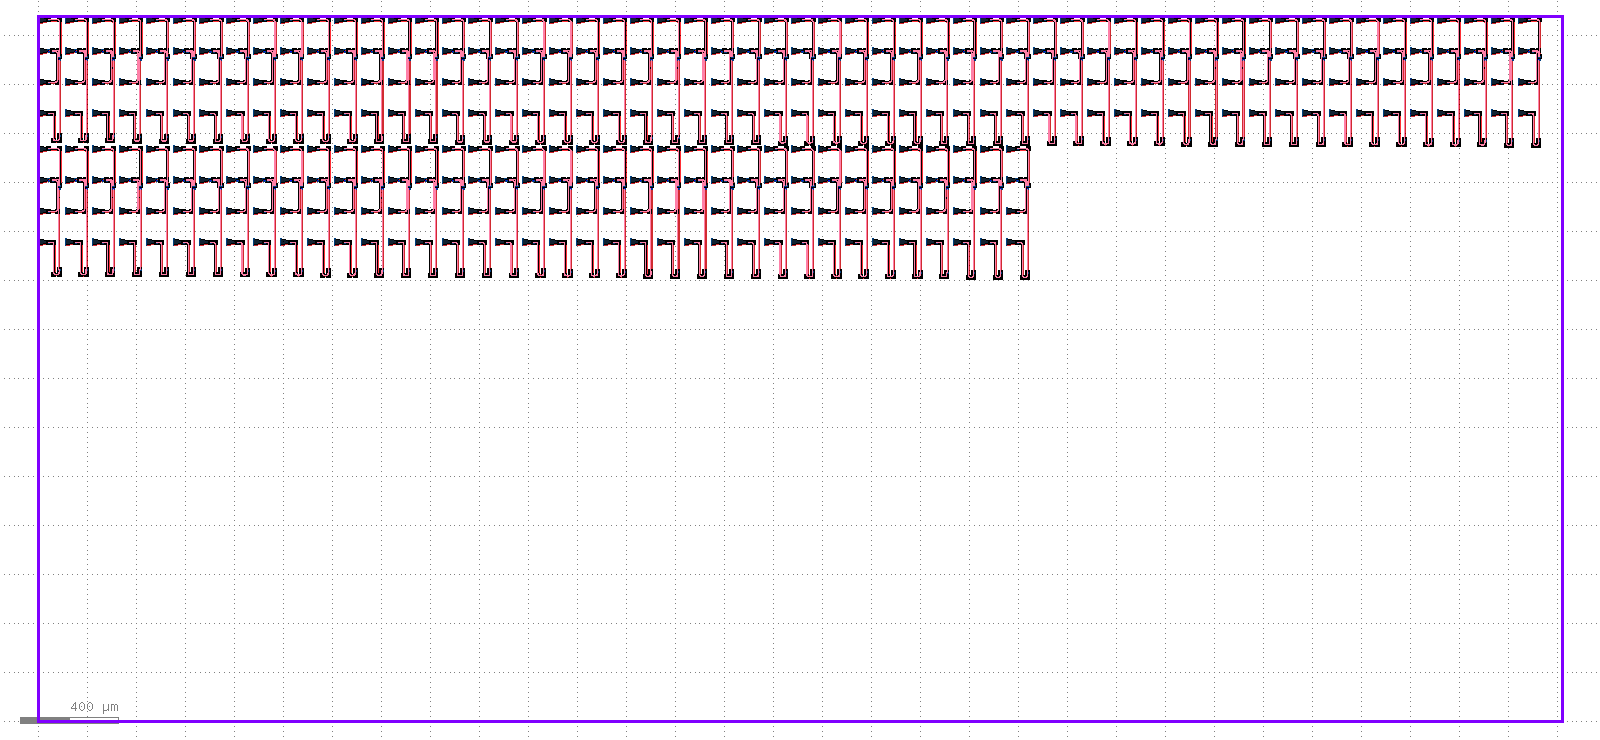

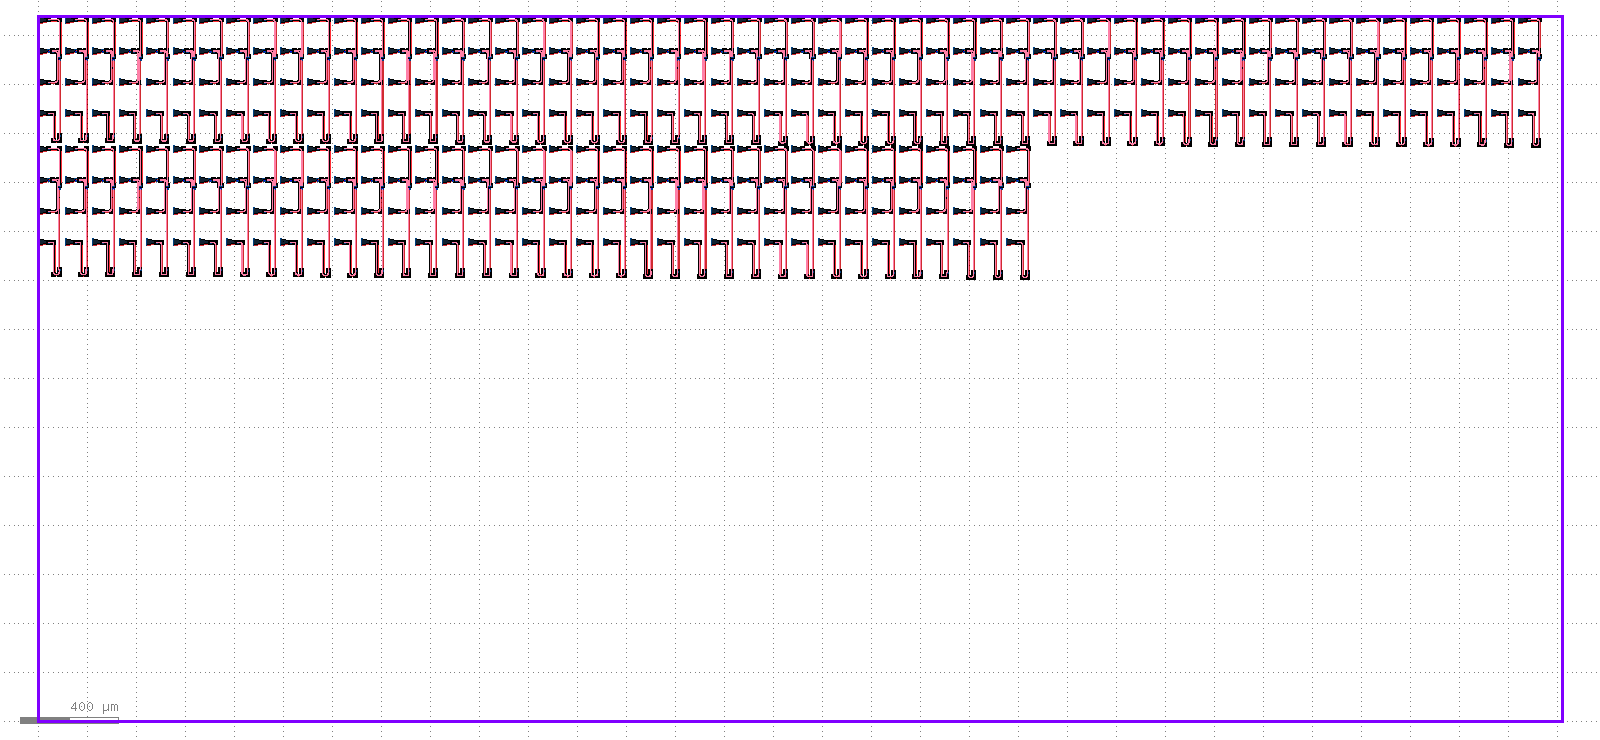

In [10]:
# Zoom out
# zoom_out(cell)
top_cell.show() # in KLayout GUI
top_cell.plot() # in the browser

## Saves the file and then flattens and uploaded a static .oas file directly to gds_in
## Could be further adjusted to automatically run merge script as a test


In [11]:
from  SiEPICfab_ZEP_export import export_for_fabrication


gds_in = os.path.join("gds_in\\", f"{top_cell_name}")


export_for_fabrication(ly, top_cell, gds_in, flatten=True)

 - Warning: You may only have one top cell in your hierarchy. Clean up using SiEPIC > Layout > Delete Extra Top Cells.
 - Warning: Exporting top cell: MateoBC
 - cell: MateoBC
saving output OASIS: gds_in\MateoBC_static.oas
Success. Layout exported successfully: 
gds_in\MateoBC_static.oas


## Total time ~80s
## Much faster than pymacro

In [ ]:
#work in progress
# klayout_path = r'C:\Users\Mateo\Desktop\KLAYOUT\klayout_app.exe -e'
# merge_script = os.path.join(folder, "merge_script", "merge_layouts.lym")

# !{klayout_path} -b -r "{merge_script}"
